## Demonstration of torch power, applied to Laue calculation

In [1]:
import functools
import timeit

from tqdm.autonotebook import tqdm
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch

/tmp/ipykernel_7557/2804679144.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Reference constants and parameters
* `LATTICE` is the 3x2 matrix of the lattice parameter $[[a, b, c], [\alpha, \beta, \gamma]]$
* `PONI` are the detector parameters $[dist, poni_1, poni_2, rot_1, rot_2, rot_3]$

The incoming $ui$ ray is always $[0, 0, 1]$, according to the pyfai convention.

In [2]:
LATTICE = torch.tensor([[125e-9, torch.pi/2], [125e-9, torch.pi/2], [125e-9, torch.pi/2]])  # germanium
PONI = torch.tensor([0.15, 0.1, 0.1, 0.0, -torch.pi/2, 0.0])  # mode laue detecor on top
DETECTOR = {"shape": (2000, 2000), "pxl": 1e-4}
GNOM_PONI = torch.tensor([1.0, 0, 0, 0.0, -3*torch.pi/4, 0.0])
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Declare differenciable functions

#### Functions to compute reciprocical lattice

In [3]:
def lattice_to_primitive(lattice: torch.Tensor) -> torch.Tensor:
    """Convert the lattice parameter into primitive vectors.

    Parameters
    ----------
    lattice : torch.Tensor
        The matrix of lattice parameter of shape (..., 3, 2).

    Returns
    -------
    primitive : torch.Tensor
        The primitive 3d column vectors (e1, e2, e3) of shape (..., 3, 3) in the orthonormal base (x, y, z).
    """
    assert isinstance(lattice, torch.Tensor), lattice.__class__.__name__
    assert lattice.shape[-2:] == (3, 2), lattice.shape

    # based on https://en.wikipedia.org/wiki/Lattice_constant#/media/File:UnitCell.png
    
    primitive = torch.empty(*lattice.shape[:-2], 3, 3, dtype=lattice.dtype, device=lattice.device)    
    lat_a, lat_b, lat_c = lattice[..., 0, 0], lattice[..., 1, 0], lattice[..., 2, 0]
    alpha, beta, gamma = lattice[..., 0, 1], lattice[..., 1, 1], lattice[..., 2, 1]
    
    # vector e1
    primitive[..., 0, 0] = lat_a * torch.sin(gamma)
    primitive[..., 1, 0] = lat_a * torch.cos(gamma)
    primitive[..., 2, 0] = 0.0

    # vector e2
    primitive[..., 0, 1] = 0.0
    primitive[..., 1, 1] = lat_b
    primitive[..., 2, 1] = 0.0

    # vector e3
    primitive[..., 0, 2] = lat_c * torch.cos(beta)
    primitive[..., 1, 2] = lat_c * torch.cos(alpha)
    primitive[..., 2, 2] = lat_c * torch.sqrt(torch.sin(alpha)**2 + torch.sin(beta)**2 - 1)

    return primitive

In [4]:
def primitive_to_reciprocal(primitive: torch.Tensor) -> torch.Tensor:
    """Convert the primitive vectors into the reciprocal base vectors.
    
    Parameters
    ----------
    primitive : torch.Tensor
        The primitive 3d column vectors (e1, e2, e3) of shape (..., 3, 3) in the orthonormal base (x, y, z).

    Returns
    -------
    reciprocal : torch.Tensor
        The reciprocal 3d column vectors (e1*, e2*, e3*) of shape (..., 3, 3) in the orthonormal base (x, y, z).
    """
    assert isinstance(primitive, torch.Tensor), primitive.__class__.__name__
    assert primitive.shape[-2:] == (3, 3), primitive.shape

    # based on https://fr.wikipedia.org/wiki/R%C3%A9seau_r%C3%A9ciproque
    
    reciprocal = torch.empty_like(primitive)
    
    volume = torch.linalg.det(primitive).unsqueeze(-1)
    volume_inv = 1.0 / volume
    reciprocal[..., 0] = volume_inv * torch.linalg.cross(primitive[..., 1], primitive[..., 2])
    reciprocal[..., 1] = volume_inv * torch.linalg.cross(primitive[..., 2], primitive[..., 0])
    reciprocal[..., 2] = volume_inv * torch.linalg.cross(primitive[..., 0], primitive[..., 1])
    return reciprocal

In [5]:
_primitive = lattice_to_primitive(LATTICE)
print(_primitive)
_reciprocal = primitive_to_reciprocal(_primitive)
print(_primitive)

tensor([[ 1.2500e-07,  0.0000e+00, -5.4639e-15],
        [-5.4639e-15,  1.2500e-07, -5.4639e-15],
        [ 0.0000e+00,  0.0000e+00,  1.2500e-07]])
tensor([[ 1.2500e-07,  0.0000e+00, -5.4639e-15],
        [-5.4639e-15,  1.2500e-07, -5.4639e-15],
        [ 0.0000e+00,  0.0000e+00,  1.2500e-07]])


#### Functions to simulate Bragg's diffraction

In [6]:
@functools.lru_cache(maxsize=16)
def _select_all_hkl(max_hkl: int, dtype: torch.dtype) -> torch.Tensor:
    # create all candidates
    steps = (
        torch.arange(max_hkl+1, dtype=torch.int16),  # [h, -k, -l] = [-h, k, l]
        torch.arange(-max_hkl, max_hkl+1, dtype=torch.int16),
        torch.arange(-max_hkl, max_hkl+1, dtype=torch.int16),
    )
    steps = torch.meshgrid(*steps, indexing="ij")
    steps = torch.cat([s.reshape(-1, 1) for s in steps], dim=1)  # (n, 3)
    # reject bad candidates
    cond = torch.sum(torch.abs(steps), dim=1) <= max_hkl
    steps = steps[cond, :]
    cond = torch.gcd(torch.gcd(steps[:, 0], steps[:, 1]), steps[:, 2]) == 1  # remove harmonics and point 0
    steps = steps[cond, :]
    # convertion cast
    steps = steps.to(dtype)
    return steps


def simul_bragg_uq(reciprocal: torch.Tensor, max_hkl: int = 10) -> torch.Tensor:
    """Simulate a complete bragg diffraction.

    Parameters
    ----------
    reciprocal : torch.Tensor
        The reciprocal 3d column vectors (e1*, e2*, e3*) of shape (..., 3, 3) in the orthonormal base (x, y, z).
    max_hkl : int, default = 10
        The max number of node taken in the reciprocal space.
        It is assumed to be a pathetic approximation of the diffraction conditions.

    Returns
    -------
    uq : torch.Tensor
        All the diffracting plane normal vector of shape (..., n, 3), with n <= (2*max_hkl + 1)**3.
    """
    assert isinstance(reciprocal, torch.Tensor), reciprocal.__class__.__name__
    assert reciprocal.shape[-2:] == (3, 3), reciprocal.shape
    assert isinstance(max_hkl, int), max_hkl.__class__.__name__
    assert max_hkl > 0, max_hkl

    hkl = _select_all_hkl(max_hkl, reciprocal.dtype).to(reciprocal.device)  # (n, 3)
    u_q = torch.sum(reciprocal[..., None, :, :] * hkl[:, None, :], dim=-1)
    u_q = u_q * torch.rsqrt(torch.sum(u_q * u_q, dim=-1, keepdim=True))  # not *= for grad propagation
    return u_q

In [7]:
def uf_to_uq(u_f: torch.Tensor) -> torch.Tensor:
    """Calculate the vector normal to the diffracting planes.

    Bijection of ``uq_to_uf``.
    Based on bragg relation uq propotional to uf - ui, with ui = [1, 0, 0].

    Parameters
    ----------
    u_f : torch.Tensor
        The normalized diffracted rays of shape (..., 3).

    Returns
    -------
    u_q : torch.Tensor
        The normalized normals of shape (..., 3).
    """
    assert isinstance(u_f, torch.Tensor), u_f.__class__.__name__
    assert u_f.shape[-1:] == (3,), u_f.shape

    u_q = u_f.clone()
    u_q[..., 2] -= 1.0  # uf - ui
    norm = torch.sum(u_q * u_q, dim=-1, keepdim=True)
    # eps = torch.finfo(u_q.dtype).eps  # to solve case no deviation
    # norm[norm <= eps] = torch.inf  # to solve case no deviation
    u_q = u_q * torch.rsqrt(norm)
    return u_q


def uq_to_uf(u_q: torch.Tensor) -> torch.Tensor:
    """Calculate the diffracted ray from q vector.

    Bijection of ``uf_to_uq``.
    Based on uf - ui = R * uq with R = 2 * <uq, -ui>.

    Parameters
    ----------
    normal : torch.Tensor
        The normalized q vectors of shape (..., 3).

    Returns
    -------
    u_f : torch.Tensor
        The normalized diffracted rays of shape (..., 3).
    """
    assert isinstance(u_q, torch.Tensor), u_q.__class__.__name__
    assert u_q.shape[-1:] == (3,), u_q.shape

    uq_dot_ui = u_q[..., 2]  # -<uq, -ui>
    q_norm = -2.0 * uq_dot_ui
    u_f = q_norm.unsqueeze(-1) * u_q
    u_f[..., 2] += 1.0  # R * uq + ui
    return u_f

In [8]:
# tests
_uq = simul_bragg_uq(_reciprocal)
assert torch.allclose(torch.linalg.vector_norm(_uq, dim=-1), torch.tensor(1.0))
_uq = _uq[_uq[..., 2] != 0, :]  # reject non deviatoric rays
print(_uq)
_uf = uq_to_uf(_uq)
print(_uf)
assert torch.allclose(torch.linalg.vector_norm(_uf, dim=-1), torch.tensor(1.0))
assert torch.allclose(_uf, uq_to_uf(-_uq))
assert torch.allclose(torch.abs(torch.sum(_uq * uf_to_uq(_uf), dim=-1)), torch.tensor(1.0))

tensor([[-4.3444e-08, -9.9388e-01, -1.1043e-01],
        [-4.3444e-08, -9.9388e-01,  1.1043e-01],
        [-4.3374e-08, -9.9228e-01, -1.2403e-01],
        ...,
        [ 9.9388e-01,  0.0000e+00, -1.1043e-01],
        [ 9.9388e-01,  0.0000e+00,  1.1043e-01],
        [ 9.9388e-01,  1.1043e-01,  4.8271e-08]])
tensor([[-9.5952e-09, -2.1951e-01,  9.7561e-01],
        [ 9.5952e-09,  2.1951e-01,  9.7561e-01],
        [-1.0760e-08, -2.4615e-01,  9.6923e-01],
        ...,
        [ 2.1951e-01,  0.0000e+00,  9.7561e-01],
        [-2.1951e-01, -0.0000e+00,  9.7561e-01],
        [-9.5952e-08, -1.0661e-08,  1.0000e+00]])


#### Functions to preject the rays on a detector plane

In [9]:
def _associate_rot(poni: torch.Tensor) -> torch.Tensor:
    rot1 = torch.empty(*poni.shape[:-1], 3, 3, dtype=poni.dtype, device=poni.device)
    cos_val = torch.cos(poni[..., 3])
    sin_val = torch.sin(poni[..., 3])
    rot1[..., 0, 0], rot1[..., 0, 1], rot1[..., 0, 2] = 1.0, 0.0, 0.0
    rot1[..., 1, 0], rot1[..., 1, 1], rot1[..., 1, 2] = 0.0, cos_val, -sin_val
    rot1[..., 2, 0], rot1[..., 2, 1], rot1[..., 2, 2] = 0.0, sin_val, cos_val
    rot2 = torch.empty_like(rot1)
    cos_val = torch.cos(poni[..., 4])
    sin_val = torch.sin(poni[..., 4])
    rot2[..., 0, 0], rot2[..., 0, 1], rot2[..., 0, 2] = cos_val, 0.0, sin_val
    rot2[..., 1, 0], rot2[..., 1, 1], rot2[..., 1, 2] = 0.0, 1.0, 0.0
    rot2[..., 2, 0], rot2[..., 2, 1], rot2[..., 2, 2] = -sin_val, 0.0, cos_val
    rot3 = torch.empty_like(rot1)
    cos_val = torch.cos(poni[..., 5])
    sin_val = torch.sin(poni[..., 5])
    rot3[..., 0, 0], rot3[..., 0, 1], rot3[..., 0, 2] = cos_val, sin_val, 0.0
    rot3[..., 1, 0], rot3[..., 1, 1], rot3[..., 1, 2] = -sin_val, cos_val, 0.0
    rot3[..., 2, 0], rot3[..., 2, 1], rot3[..., 2, 2] = 0.0, 0.0, 1.0
    return rot3 @ rot2 @ rot1


def ray_to_detector(ray: torch.Tensor, poni: torch.Tensor) -> torch.Tensor:
    """Find the intersection of the light ray with the detector.
    
    Parameters
    ----------
    ray : torch.Tensor
        The unitary rays vectors of shape (*r, 3).
    poni : torch.Tensor
        The point of normal incidence, callibration parameters according the pyfai convention.
        https://www.silx.org/doc/pyFAI/latest/geometry.html#detector-position
        The shape is (*p, 6).

    Returns
    -------
    point : torch.Tensor
        The 2d points in the referencial of the detector of shape (*p, *r, 2).
    dist : torch.Tensor
        The algebrical distance of the ray between the sample and the detector.
        a positive value means that the beam is moving towards the detector.
        A negative value means it is moving away.
        The shape is (*p, *r).
    """
    assert isinstance(ray, torch.Tensor), ray.__class__.__name__
    assert ray.shape[-1:] == (3,), ray.shape
    assert isinstance(poni, torch.Tensor), poni.__class__.__name__
    assert poni.shape[-1:] == (6,), poni.shape
    
    rot = _associate_rot(poni)
    rectified_ray = (
        rot[..., *((None,) * (ray.ndim - 1)), :, :] @ ray[*((None,) * (poni.ndim - 1)), ..., None]
    ).squeeze(-1)  # (*p, *r, 3)
    ray_dist = poni[..., *((None,) * (ray.ndim - 1)), 0] / rectified_ray[..., 2]
    point = ray_dist.unsqueeze(-1) * rectified_ray[..., :2]
    point = point + poni[..., *((None,) * (ray.ndim - 1)), 1:3]  # detector shift

    return point, ray_dist


def detector_to_ray(point: torch.Tensor, poni: torch.Tensor) -> torch.Tensor:
    """Find light ray witch intersected on the detector.
    
    Parameters
    ----------
    point : torch.Tensor
        The 2d points in the referencial of the detector of shape (*p, *r, 2).
    poni : torch.Tensor
        The point of normal incidence, callibration parameters according the pyfai convention.
        https://www.silx.org/doc/pyFAI/latest/geometry.html#detector-position
        The shape is (*p, 6).

    Returns
    -------
    ray : torch.Tensor
        The unitary rays vectors of shape (*p, *r, 3).
    """
    assert isinstance(point, torch.Tensor), point.__class__.__name__
    assert point.shape[-1:] == (2,), point.shape
    assert isinstance(poni, torch.Tensor), poni.__class__.__name__
    assert poni.shape[-1:] == (6,), poni.shape

    point = point - poni[..., *((None,) * (point.ndim - 1)), 1:3]  # detector shift
    ray = torch.empty(*point.shape[:-1], 3, dtype=point.dtype, device=point.device)
    ray[..., :2] = point
    ray[..., 2] = poni[..., *((None,) * (point.ndim - 1)), 0]
    rot = _associate_rot(poni)
    ray = (rot.mT @ ray[..., None]).squeeze(-1)
    ray  = ray * torch.rsqrt(torch.sum(ray * ray, dim=-1, keepdim=True))  # not *= for grad propagation
    return ray

In [10]:
_point, _dist = ray_to_detector(_uf, PONI)
print(_point)
print(_dist)
_ray = detector_to_ray(_point, PONI)
print(_ray)
assert torch.allclose(torch.linalg.vector_norm(_ray, dim=-1), torch.tensor(1.0))
assert torch.allclose(torch.abs(torch.sum(_uf * _ray, dim=-1)), torch.tensor(1.0))

tensor([[ 2.8013e+06,  6.3029e+05],
        [ 4.4279e+06, -9.9627e+05],
        [ 2.7366e+06,  6.9501e+05],
        ...,
        [-5.6667e-01,  1.0000e-01],
        [ 7.6667e-01,  1.0000e-01],
        [ 1.0740e+06,  1.1145e-01]])
tensor([-2.8713e+06, -4.5386e+06, -2.8235e+06, -4.7458e+06, -2.4272e+06,
        -2.4914e+06, -2.7674e+06, -5.0465e+06, -1.0699e+07,  9.9517e+07,
        -2.7015e+06, -5.5204e+06, -2.8713e+06, -2.5364e+06, -2.4272e+06,
        -2.6242e+06, -6.3730e+06, -9.9516e+07,  8.3339e+06,  4.5386e+06,
        -4.5386e+06, -2.7674e+06, -2.5364e+06, -8.3339e+06,  5.0465e+06,
         2.8713e+06, -9.9516e+07, -8.3339e+06, -5.0465e+06, -2.6242e+06,
        -2.4511e+06, -1.7158e+07,  6.3730e+06,  2.7674e+06,  2.5364e+06,
         2.4272e+06,  1.0699e+07,  9.9517e+07, -6.3730e+06, -2.4511e+06,
         1.7158e+07,  2.6242e+06,  2.4272e+06,  2.4914e+06,  4.5386e+06,
         4.7458e+06,  5.0465e+06,  5.5204e+06,  6.3730e+06,  8.3339e+06,
         1.7158e+07, -1.7158e+07, -3.431

### Use and associate the functions

In [11]:
def simulate(lattice: torch.Tensor, poni: torch.Tensor) -> torch.Tensor:
    """Simulate a Laue diagram for lattice parameters and calibration file.

    Parameters
    ----------
    lattice : torch.Tensor
        Cristal parameters, see ``lattice_to_primitive``.
    poni : torch.Tensor
        Configuration file, see ``ray_to_detector``.

    Returns
    -------
    points : torch.Tensor
        The projecteted point on the detector.
    """
    primitive = lattice_to_primitive(lattice)
    reciprocal = primitive_to_reciprocal(primitive)
    u_q = simul_bragg_uq(reciprocal, 20)
    u_f = uq_to_uf(u_q)
    points, dists = ray_to_detector(u_f, poni)
    points = points[dists > 0, :]  # ray wrong direction => virtual intersection
    points = points[points[..., 0] > 0, :]  # out of detector top
    points = points[points[..., 0] < DETECTOR["shape"][0] * DETECTOR["pxl"], :]  # out of detector bottom
    points = points[points[..., 1] > 0, :]  # out of detector left
    points = points[points[..., 1] < DETECTOR["shape"][1] * DETECTOR["pxl"], :]  # out of detector right
    return points

#### Simple basic test and timing

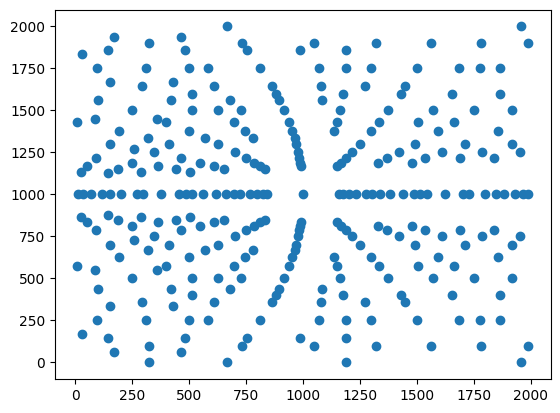

In [12]:
# simple plot test
plt.scatter(*(simulate(LATTICE, PONI) / DETECTOR["pxl"]).movedim(-1, 0)); plt.show()

In [13]:
# simple timing

BATCH = 100  # number of simulated diagrams

# case float64
lattice, poni = LATTICE.clone().to(torch.float64), PONI.clone().to(torch.float64)
speed = min(timeit.repeat(lambda: simulate(lattice, poni), repeat=10, number=BATCH)) / BATCH
print(f"float64: it takes {speed*1e6:.2f}us by simulation <=> {1.0/speed:.2f}Hz")

# case float32
lattice, poni = LATTICE.clone().to(torch.float32), PONI.clone().to(torch.float32)
speed = min(timeit.repeat(lambda: simulate(lattice, poni), repeat=10, number=BATCH)) / BATCH
print(f"float32: it takes {speed*1e6:.2f}us by simulation <=> {1.0/speed:.2f}Hz")

# case float64 batched
lattice, poni = LATTICE.clone().to(torch.float64), PONI.clone().to(torch.float64)
lattice = lattice[None, :, :].expand(BATCH, -1, -1)
speed = min(timeit.repeat(lambda: simulate(lattice, poni), repeat=10, number=1)) / BATCH
print(f"float64 batched: it takes {speed*1e6:.2f}us by simulation <=> {1.0/speed:.2f}Hz")

# case float32 batched
lattice, poni = LATTICE.clone().to(torch.float32), PONI.clone().to(torch.float32)
lattice = lattice[None, :, :].expand(BATCH, -1, -1)
speed = min(timeit.repeat(lambda: simulate(lattice, poni), repeat=10, number=1)) / BATCH
print(f"float32 batched: it takes {speed*1e6:.2f}us by simulation <=> {1.0/speed:.2f}Hz")

# case float64 batched compiled
lattice, poni = LATTICE.clone().to(torch.float64), PONI.clone().to(torch.float64)
lattice = lattice[None, :, :].expand(BATCH, -1, -1)
simulate_comp = torch.compile(simulate, dynamic=False)
speed = min(timeit.repeat(lambda: simulate_comp(lattice, poni), repeat=10, number=1)) / BATCH
print(f"float64 batched compiled: it takes {speed*1e6:.2f}us by simulation <=> {1.0/speed:.2f}Hz")

# case float32 batched compiled
lattice, poni = LATTICE.clone().to(torch.float32), PONI.clone().to(torch.float32)
lattice = lattice[None, :, :].expand(BATCH, -1, -1)
simulate_comp = torch.compile(simulate, dynamic=False)
speed = min(timeit.repeat(lambda: simulate_comp(lattice, poni), repeat=10, number=1)) / BATCH
print(f"float32 batched compiled: it takes {speed*1e6:.2f}us by simulation <=> {1.0/speed:.2f}Hz")

if DEVICE.type == "cuda":
    # case float64 batched compiled gpu
    lattice, poni = LATTICE.clone().to(dytpe=torch.float64, device=DEVICE), PONI.clone().to(dytpe=torch.float64, device=DEVICE)
    lattice = lattice[None, :, :].expand(BATCH, -1, -1)
    simulate_comp = torch.compile(simulate, dynamic=False)
    speed = min(timeit.repeat(lambda: simulate_comp(lattice, poni), repeat=10, number=1)) / BATCH
    print(f"float64 batched compiled gpu: it takes {speed*1e6:.2f}us by simulation <=> {1.0/speed:.2f}Hz")
    
    # case float32 batched compiled gpu
    lattice, poni = LATTICE.clone().to(dytpe=torch.float32, device=DEVICE), PONI.clone().to(dytpe=torch.float32, device=DEVICE)
    lattice = lattice[None, :, :].expand(BATCH, -1, -1)
    simulate_comp = torch.compile(simulate, dynamic=False)
    speed = min(timeit.repeat(lambda: simulate_comp(lattice, poni), repeat=10, number=1)) / BATCH
    print(f"float32 batched compiled gpu: it takes {speed*1e6:.2f}us by simulation <=> {1.0/speed:.2f}Hz")

float64: it takes 4615.17us by simulation <=> 216.68Hz
float32: it takes 4067.35us by simulation <=> 245.86Hz
float64 batched: it takes 2191.92us by simulation <=> 456.22Hz
float32 batched: it takes 1269.41us by simulation <=> 787.77Hz
float64 batched compiled: it takes 756.38us by simulation <=> 1322.09Hz
float32 batched compiled: it takes 443.65us by simulation <=> 2254.04Hz


#### Propagation of positional uncertainty

Let $f$ be a derivable function such that $\tilde{y} = f(\tilde{x})$.<br>
Let $\epsilon$ be the uncertainty on the image such that $\tilde{y} = y + \epsilon$ and $\eta$ the uncertainty on the antecedent such that $\tilde{x} = x + \eta$.<br>

By definition, $\frac{df(x)}{dx} = \lim\limits_{\eta \to 0} \frac{f(x + \eta) - f(x)}{\eta}$


$\tilde{x} = x + \epsilon \Leftrightarrow \tilde{y} = f(x + \epsilon)$

### Projection gnomonic

In [35]:
def cam_to_gnom(cam_point: torch.Tensor, cam_poni: torch.Tensor, gnom_poni: torch.Tensor) -> torch.Tensor:
    """Project the camera point into the gnomonic space.

    Parameters
    ----------
    cam_point : torch.Tensor
        The projected ray uf on the detector. Transmitted to ``detector_to_ray``.
    cam_poni : torch.Tensor
        The real detector callibration parameters. Transmitted to ``detector_to_ray``.
    gnom_poni : torch.Tensor
        The virtual gnomonic detector position. Transmitted to ``ray_to_detector``.

    Returns
    -------
    gnom_point : torch.Tensor
        The projected ray uq on the virtual gnomonic detector.
    """
    u_f = detector_to_ray(cam_point, cam_poni)
    u_q = uf_to_uq(u_f)
    gnom_point, _ = ray_to_detector(u_q, gnom_poni)
    return gnom_point


def gnom_to_cam(gnom_point: torch.Tensor, gnom_poni: torch.Tensor, cam_poni: torch.Tensor) -> torch.Tensor:
    """Project the camera point into the gnomonic space.

    Parameters
    ----------
    gnom_point : torch.Tensor
        The projected ray uq on the virtual gnomonic detector. Transmitted to ``detector_to_ray``.
    gnom_poni : torch.Tensor
        The virtual gnomonic detector position. Transmitted to ``ray_to_detector``.
    cam_poni : torch.Tensor
        The real detector callibration parameters. Transmitted to ``detector_to_ray``.

    Returns
    -------
    cam_point : torch.Tensor
        The projected ray uf on the detector.
    """
    u_q = detector_to_ray(gnom_point, gnom_poni)
    u_f = uq_to_uf(u_q)
    cam_point, _ = ray_to_detector(u_f, cam_poni)
    return cam_point

#### Points projection

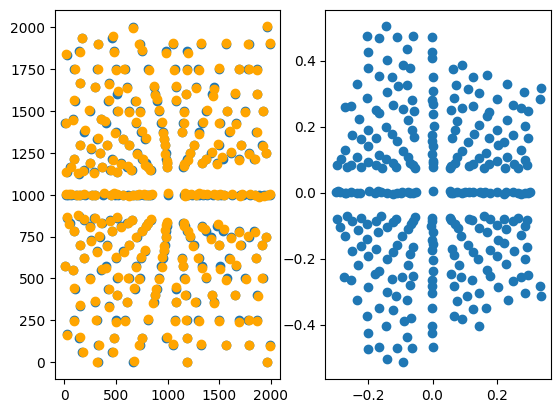

In [36]:
# create noisy diagram
cam_point = simulate(LATTICE, PONI)
exp_point = cam_point + torch.randn_like(cam_point) * (0.01 * cam_point.std())
gnom_point = cam_to_gnom(exp_point, PONI, GNOM_PONI)

plt.subplot(1, 2, 1)
plt.scatter(*(cam_point / DETECTOR["pxl"]).movedim(-1, 0))
plt.scatter(*(exp_point / DETECTOR["pxl"]).movedim(-1, 0), color="orange")
plt.subplot(1, 2, 2)
plt.scatter(*gnom_point.movedim(-1, 0))
plt.show()

#### Image projection

  0%|          | 0/299 [00:00<?, ?it/s]

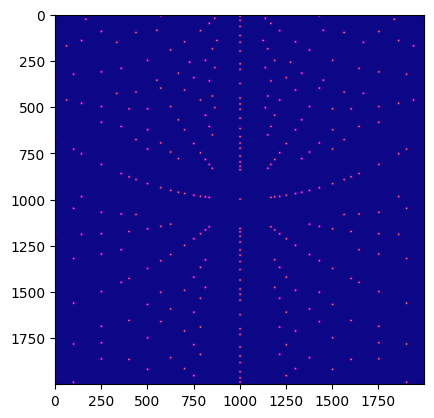

In [58]:
# create a virtual image

from laueimproc.gmm.gmm import gmm2d

pixels = torch.meshgrid(torch.arange(DETECTOR["shape"][0]), torch.arange(DETECTOR["shape"][1]), indexing="ij")
pixels = torch.cat([p.ravel().unsqueeze(-1)for p in pixels], dim=1)  # shape (n, 2)
spots_pos = simulate(LATTICE, PONI) / DETECTOR["pxl"]  # shape (k, 2)
img = torch.zeros(DETECTOR["shape"]).ravel()
for i in tqdm(range(len(spots_pos))):
    img += gmm2d(pixels, spots_pos[i][None, :], 10.0*torch.eye(2)[None, :, :], torch.tensor(1.0)[None])
img = img.reshape(*DETECTOR["shape"])
img /= img.amax()

# to numpy
img_f32 = img.numpy(force=True)
img *= 65335
img + 0.5
img_u16 = img.numpy().astype(np.uint16)

plt.imshow(img_u16, cmap="plasma")
plt.show()

In [50]:
# create map convertion for cv2

# forward for estimation of shape
i_max = DETECTOR["shape"][0] * DETECTOR["pxl"]
j_max = DETECTOR["shape"][1] * DETECTOR["pxl"]
cam = torch.tensor(
    [[0, 0], [i_max/2, 0], [i_max, 0], [i_max/2, j_max/2], [i_max/2, j_max], [i_max/2, j_max], [0, j_max], [0, j_max/2]]
)
gnom = cam_to_gnom(cam, PONI, GNOM_PONI)

# backward for interpolation
gnom_shape = DETECTOR["shape"]  # best shape diff
gnom = (
    torch.linspace(gnom[:, 0].amin(), gnom[:, 0].amax(), gnom_shape[0]),  
    torch.linspace(gnom[:, 1].amin(), gnom[:, 1].amax(), gnom_shape[1]),
)
gnom = torch.meshgrid(*gnom, indexing="ij")
gnom = torch.cat([g.ravel().unsqueeze(1) for g in gnom], dim=1)
cam = gnom_to_cam(gnom, GNOM_PONI, PONI)
cam /= DETECTOR["pxl"]

# to cv2 map
map1 = cam[..., 0].reshape(gnom_shape).numpy().astype(np.float32)
map2 = cam[..., 1].reshape(gnom_shape).numpy().astype(np.float32)

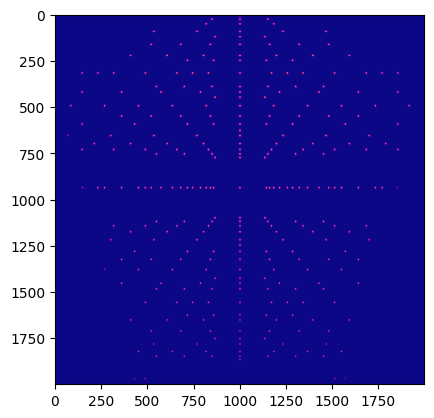

uint16 bilinear: it takes 38.21ms by image
uint16 bicubic: it takes 68.64ms by image
float32 bilinear: it takes 44.72ms by image
float32 bicubic: it takes 143.02ms by image


In [59]:
# interpolation

# simple convertion
gnom_img = cv2.remap(img_u16, map2, map1, interpolation=cv2.INTER_LINEAR)
plt.imshow(gnom_img, cmap="plasma")
plt.show()

BATCH = 10

# case uint16 bilinear
speed = min(timeit.repeat(lambda: cv2.remap(img_u16, map2, map1, interpolation=cv2.INTER_LINEAR), repeat=10, number=BATCH)) / BATCH
print(f"uint16 bilinear: it takes {speed*1e3:.2f}ms by image")

# case uint16 bicubic
speed = min(timeit.repeat(lambda: cv2.remap(img_u16, map2, map1, interpolation=cv2.INTER_CUBIC), repeat=10, number=BATCH)) / BATCH
print(f"uint16 bicubic: it takes {speed*1e3:.2f}ms by image")

# case float32 bilinear
speed = min(timeit.repeat(lambda: cv2.remap(img_f32, map2, map1, interpolation=cv2.INTER_LINEAR), repeat=10, number=BATCH)) / BATCH
print(f"float32 bilinear: it takes {speed*1e3:.2f}ms by image")

# case float32 bicubic
speed = min(timeit.repeat(lambda: cv2.remap(img_f32, map2, map1, interpolation=cv2.INTER_CUBIC), repeat=10, number=BATCH)) / BATCH
print(f"float32 bicubic: it takes {speed*1e3:.2f}ms by image")